<a href="https://colab.research.google.com/github/gdelaserre/insee-covid/blob/main/Insee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectifs de l'analyse

Cette analyse visualise les données brutes de surmortalité en France telles que rapportées par l'INSEE depuis Mars 2020, et les compare aux deux années précédentes afin d'évaluer l'impact net du COVID0-19 en termes de mortalité par tranche d'âge. Notez que les mois de Janvier et Février, qui ont été moins mortels en 2020 qu'en 2019 et 2018, ne sont pas inclus dans les données de l'INSEE, et ce en raison d'un début de propagation de l'épidémie à partir de Mars 2020. Les résultats ci-dessous seront donc légèrement sur-estimés par rapport à une analyse sur l'année complète. 



This data analysis investigates excess deaths in France as reported by the INSEE since March of 2020 compared to 2018 and 2019 in an attempt to evaluate the net impact of COVID-19 on overall mortality by age groups. Note that the months January and February, which have been less deadly in 2020 than the two previous years, are not included in the INSEE's data as the pandemic started taking its toll in March. Therefore the results below will be slightly overestimated compared to when taking the full year into account. 

#Import files & libraries / Import des fichiers et librairies

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import Markdown as md


age_file = pd.read_csv('/content/drive/MyDrive/Insee/original data/2020-12-11_deces_parsexe_age_jour_France.csv', delimiter = ';')
age_df = pd.DataFrame(age_file)
age_df.head(5)

,Date_evenement,Femmes_0_24ans_Deces2020,Femmes_25_49ans_Deces2020,Femmes_50_64ans_Deces2020,Femmes_65_74ans_Deces2020,Femmes_75_84ans_Deces2020,Femmes_85ans_plus_Deces2020,Hommes_0_24ans_Deces2020,Hommes_25_49ans_Deces2020,Hommes_50_64ans_Deces2020,Hommes_65_74ans_Deces2020,Hommes_75_84ans_Deces2020,Hommes_85ans_plus_Deces2020,Femmes_0_24ans_Deces2019,Femmes_25_49ans_Deces2019,Femmes_50_64ans_Deces2019,Femmes_65_74ans_Deces2019,Femmes_75_84ans_Deces2019,Femmes_85ans_plus_Deces2019,Hommes_0_24ans_Deces2019,Hommes_25_49ans_Deces2019,Hommes_50_64ans_Deces2019,Hommes_65_74ans_Deces2019,Hommes_75_84ans_Deces2019,Hommes_85ans_plus_Deces2019,Femmes_0_24ans_Deces2018,Femmes_25_49ans_Deces2018,Femmes_50_64ans_Deces2018,Femmes_65_74ans_Deces2018,Femmes_75_84ans_Deces2018,Femmes_85ans_plus_Deces2018,Hommes_0_24ans_Deces2018,Hommes_25_49ans_Deces2018,Hommes_50_64ans_Deces2018,Hommes_65_74ans_Deces2018,Hommes_75_84ans_Deces2018,Hommes_85ans_plus_Deces2018,Zone,LibelleZone
0,01/03/2020,5,14,63,90,180,538,11,42,132,161,202,344,3,23,72,105,158,626,9,52,119,158,196,351,8,24,72,106,204,658,11,46,129,204,256,418,FE,France
1,02/03/2020,12,30,114,175,330,1104,20,74,271,319,436,682,6,36,143,206,313,1231,26,87,240,338,444,712,18,45,146,226,405,1365,21,96,284,409,513,799,FE,France
2,03/03/2020,20,59,185,275,482,1591,26,123,413,499,652,1015,14,50,214,292,479,1781,33,130,358,509,646,1024,25,65,217,305,613,2086,32,134,414,590,761,1213,FE,France
3,04/03/2020,28,77,245,360,642,2178,36,168,546,660,878,1338,21,72,282,390,653,2398,45,171,473,684,854,1367,31,98,300,393,798,2802,39,180,548,775,989,1592,FE,France
4,05/03/2020,33,98,312,461,780,2714,46,206,677,832,1112,1667,27,92,345,481,836,2968,59,215,610,868,1063,1714,34,114,363,493,1013,3529,46,222,703,974,1262,1993,FE,France


# Cleaning the data / Recalibrage de la donnée

In [26]:
# drop useless columns
age_df = age_df.drop(['Zone', 'LibelleZone'], axis = 1)
# transform sexe_age column into rows
age_df_clean = age_df.melt(id_vars=['Date_evenement'], 
        var_name="sexe_age", 
        value_name="deces")

# transform sexe_age column into multiple values: année, sexe, groupe_age
age_df_clean['annee'] = age_df_clean['sexe_age'].str.strip().str[-4:].astype(int)
age_df_clean['sexe'] = age_df_clean['sexe_age'].str.strip().str[:6]
age_df_clean['groupe_age'] = age_df_clean['sexe_age'].str.strip().str[7:-13]

# regroupement des groupes d'age:
## '0_24' '25_49' '50_64' => 'moins_de_65'
## '65_74' '75_84' => '65_84'

# create a list of our conditions
conditions = [
    (age_df_clean['groupe_age'] == '0_24') | (age_df_clean['groupe_age'] == '25_49') |(age_df_clean['groupe_age'] == '50_64'),
    (age_df_clean['groupe_age'] == '65_74') | (age_df_clean['groupe_age'] == '75_84'),
    (age_df_clean['groupe_age'] == '85ans_p')
    ]

# create a list of the values we want to assign for each condition
values = ['moins_de_65', '65_84', '85_et_plus']

# create a new column and use np.select to assign values to it using our lists as arguments
age_df_clean['age'] = np.select(conditions, values)
age_df_clean['Date_evenement'] = pd.to_datetime(age_df_clean['Date_evenement'],format='%d/%m/%Y')

# clean up flat file and save it
flat_df = age_df_clean.drop(['sexe_age'], axis = 1)
flat_df['jour'] = flat_df.Date_evenement.dt.strftime('%d')
flat_df['mois'] = flat_df.Date_evenement.dt.strftime('%m')
new_index = ['mois', 'jour', 'annee', 'Date_evenement', 'age', 'groupe_age','sexe','deces']
flat_df = flat_df.reindex(columns = new_index)
flat_df.to_csv('/content/drive/MyDrive/Insee2020-12-11_deces_parsexe_age_jour_France_flat.csv')

# transform flat file into pivot table
pivot_df = flat_df.pivot_table(values = 'deces', index = ['mois','jour'], columns = ['annee','sexe','age','groupe_age'], aggfunc = sum)
pivot_df.to_csv('/content/drive/MyDrive/Insee/2020-12-11_deces_parsexe_age_jour_France_pivot.csv')

# simplify pivot
age_pivot = flat_df.pivot_table(values = 'deces', index = ['mois','jour'], columns = ['annee','age'], aggfunc = sum)
age_pivot.head(5)

annee      2018                         ...  2020                       
age       65_84 85_et_plus moins_de_65  ... 65_84 85_et_plus moins_de_65
mois jour                               ...                             
03   01     770       1076         290  ...   633        882         267
     02    1553       2164         610  ...  1260       1786         521
     03    2269       3299         887  ...  1908       2606         826
     04    2955       4394        1196  ...  2540       3516        1100
     05    3742       5522        1482  ...  3185       4381        1372

[5 rows x 9 columns]

In [27]:
# add average of past 2 years and compare data
ages = ['moins_de_65', '65_84','85_et_plus']

for age in ages: # moyenne 2018- 2019
  age_pivot['avg_2018_19', age] = (age_pivot[2018,age] + age_pivot[2019,age]) / 2

for age in ages: # surplus de mortalité en volume
  age_pivot['surmortalite_total', age] = age_pivot[2020, age] - age_pivot['avg_2018_19', age] 

for age in ages: # surmortalite en %
  age_pivot['surmortalite_croissance', age] = 100 * age_pivot['surmortalite_total', age] / age_pivot['avg_2018_19', age] 

age_pivot.head(5)

annee      2018             ... surmortalite_croissance           
age       65_84 85_et_plus  ...                   65_84 85_et_plus
mois jour                   ...                                   
03   01     770       1076  ...               -8.723864 -14.076961
     02    1553       2164  ...              -11.702873 -13.026540
     03    2269       3299  ...               -9.034565 -14.613368
     04    2955       4394  ...               -8.236994 -13.812967
     05    3742       5522  ...               -8.869814 -14.131713

[5 rows x 18 columns]

In [28]:
# select only the data that we want for visualization 

clean_data = age_pivot.drop([2018,2019, 2020], axis = 1)
clean_data = clean_data.reset_index(level=['mois','jour'])
clean_data['Date'] = clean_data['jour'].astype(str)  + "/" + clean_data['mois'].astype(str) + "/2020"
clean_data.set_index('Date', inplace = True)
clean_data.tail(5)

annee      mois jour avg_2018_19  ... surmortalite_croissance                      
age                  moins_de_65  ...             moins_de_65      65_84 85_et_plus
Date                              ...                                              
26/11/2020   11   26     70248.0  ...                0.967999  12.366070  14.122141
27/11/2020   11   27     70523.5  ...                0.939403  12.380553  14.152887
28/11/2020   11   28     70799.5  ...                0.886306  12.328700  14.198945
29/11/2020   11   29     71085.0  ...                0.800450  12.303691  14.171084
30/11/2020   11   30     71360.0  ...                0.751121  12.305323  14.190483

[5 rows x 11 columns]

# Visualize the Data / Visualisation de la donnée

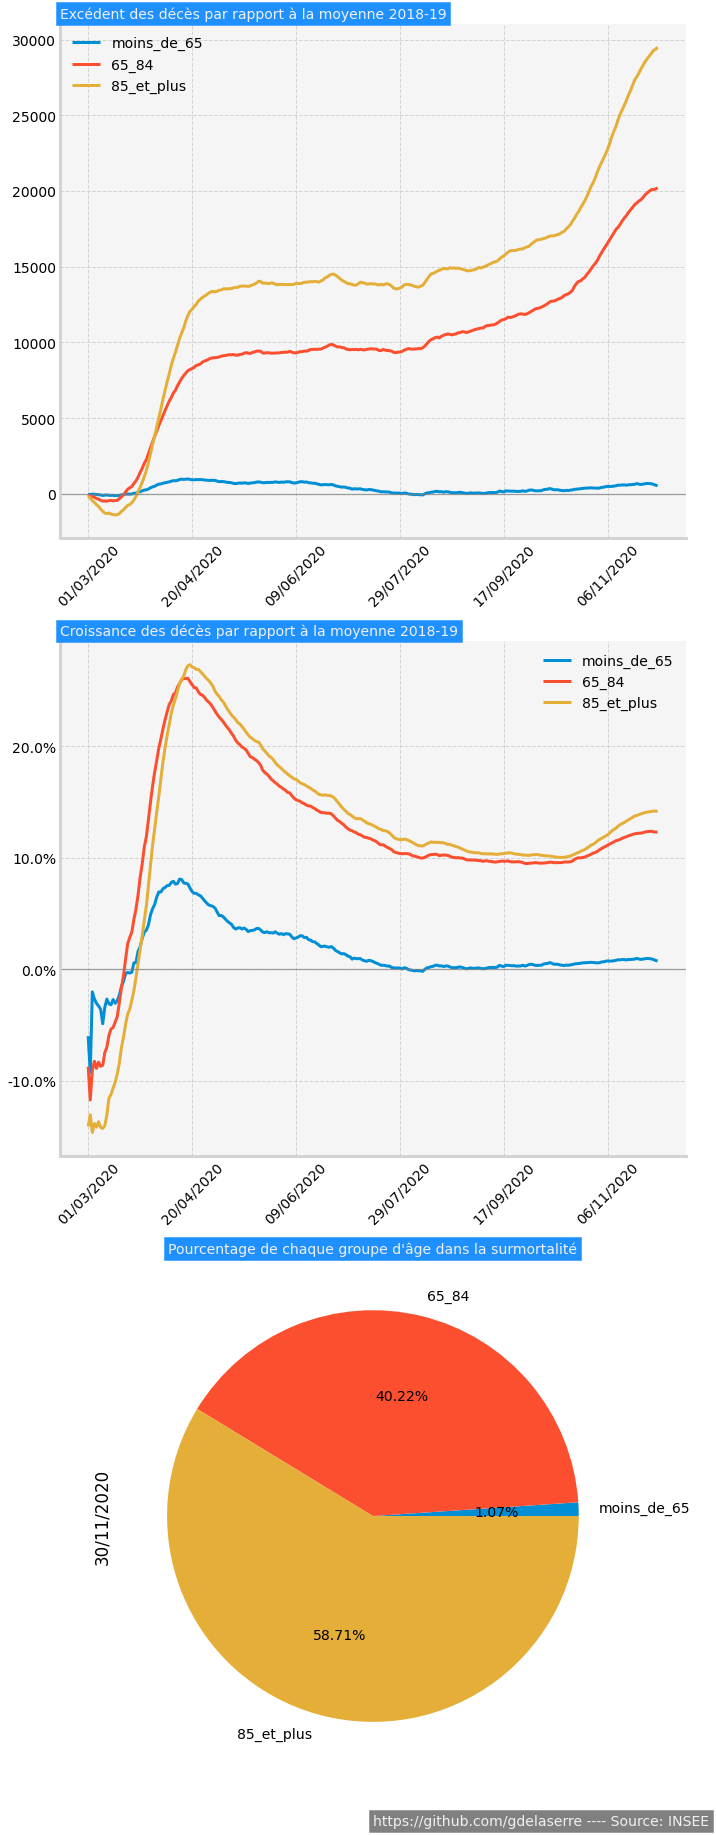

In [29]:
fig, axes = plt.subplots(3, figsize = (10,30), facecolor='white')
ax1 = clean_data['surmortalite_total'].plot(ax = axes[0], linewidth=3)
ax2 = clean_data['surmortalite_croissance'].plot(ax = axes[1], linewidth=3)
ax3 = clean_data['surmortalite_total'].iloc[-1].plot.pie(autopct = '%.2f%%', textprops={'fontsize': 14})

ax1.set_title('Excédent des décès par rapport à la moyenne 2018-19', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dodgerblue', loc = 'left')
ax2.set_title('Croissance des décès par rapport à la moyenne 2018-19',  fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dodgerblue', loc = 'left')
ax3.set_title ('Pourcentage de chaque groupe d\'âge dans la surmortalité',  fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dodgerblue', loc = 'center')
ax3.text(0,-1.5,'https://github.com/gdelaserre ---- Source: INSEE',fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

for ax in (ax1, ax2):
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left']. set_color('lightgrey')
  ax.spines['bottom']. set_color('lightgrey')
  ax.legend(frameon=False)
  ax.tick_params(axis='x', labelrotation= 45)
  ax.grid(b=True, which='major', color='lightgrey', linestyle='--')
  ax.set_xlabel('')
  ax.axhline(y = 0, color = 'grey', linewidth = 1.3, alpha = .7)
  ax.set_facecolor('whitesmoke')

In [30]:
# display conclusion in markdown cell

total = clean_data['surmortalite_total'].iloc[-1].sum().astype(int)
perc = 100 * (age_pivot[2020].iloc[-1].sum() / age_pivot['avg_2018_19'].iloc[-1].sum() - 1)
latest_date = clean_data.index[-1]
conclusion = '##Entre le 01/03/2020 et le {}, il y avait {} morts en plus par rapport à la moyenne des deux années précédentes sur la même période, soit une augmentation totale de {:.2f}%. '.format(latest_date,total, perc) 
md(conclusion)


##Entre le 01/03/2020 et le 30/11/2020, il y avait 50251 morts en plus par rapport à la moyenne des deux années précédentes sur la même période, soit une augmentation totale de 11.33%. 

# Comparaison avec la croissance de la mortalité par an depuis 1946

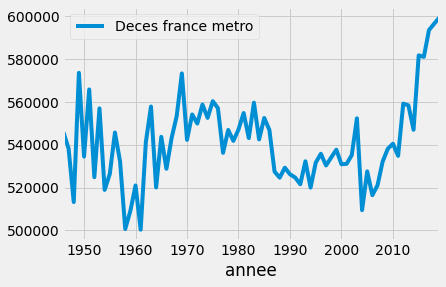

In [31]:
deces_1946 = pd.read_csv('/content/drive/MyDrive/Insee/original data/deces_1946.csv', delimiter = ',')

plt.style.use('fivethirtyeight')
deces_1946.plot(x = 'annee', y = 'Deces france metro', xlim = (1946, 2019))
plt.show()

In [32]:
def moyenne(year):
    last_year = year - 1
    two_years_ago = year - 2
    if year > 1947:
      v1 = deces_1946.loc[deces_1946['annee'] == last_year, 'Deces france metro'].iloc[0]
      v2 = deces_1946.loc[deces_1946['annee'] == two_years_ago, 'Deces france metro'].iloc[0]
      v = (v2 + v1) / 2
    else: v = 0
    return v
deces_1946['moyenne'] = deces_1946['annee'].apply(moyenne)
deces_1946['croissance_vs_moyenne_2_annees'] = round(100 * (deces_1946['Deces france metro'] / deces_1946['moyenne'] - 1), 2)
graph_data = deces_1946[2:].drop(columns = ['Deces france metro', 'moyenne'])
graph_data.head(5)

,annee,croissance_vs_moyenne_2_annees
2,1948,-5.32
3,1949,9.11
4,1950,-1.64
5,1951,2.13
6,1952,-4.60


''

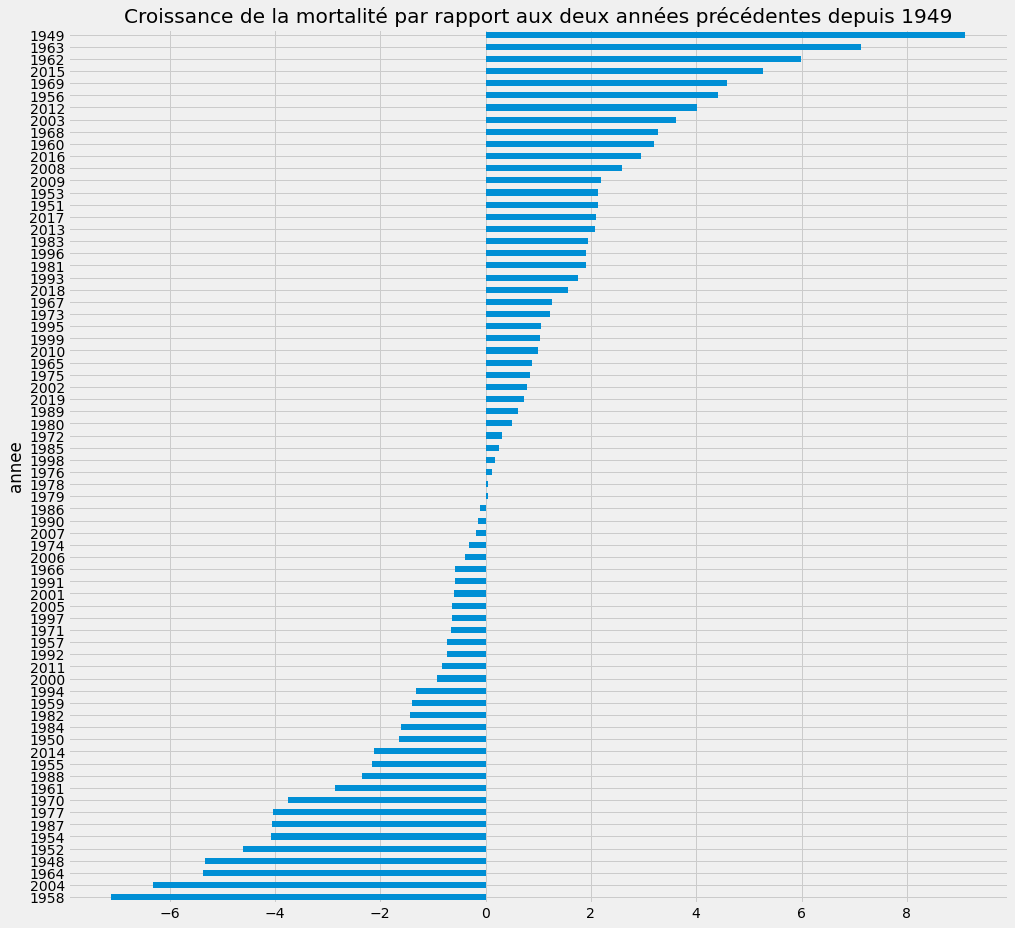

In [33]:
plt.style.use('fivethirtyeight')
graph_data = graph_data.sort_values(by = 'croissance_vs_moyenne_2_annees', ascending = True)
graph_data.plot(x = 'annee', y = 'croissance_vs_moyenne_2_annees' , kind = 'barh', figsize = (15,15), title = "Croissance de la mortalité par rapport aux deux années précédentes depuis 1949", legend = None)
;